# Final Project

Team members: Enze Zhou, Vahan Geghamyan

## 1. Introduction

In this project, we want to implement the algorithms proposed by [Ma and Wu (2022)](#Ma2022) to accelerate the simulation of rough volatility processes. In particular, [Ma and Wu (2022)](#Ma2022) focuses on the rough Heston model

$$
\begin{equation}
\begin{aligned}
\mathrm{d} S_t &= r S_t \mathrm{d} t+S_t \sqrt{V_t} \mathrm{d} W_t, \\
V_t &= V_0+\frac{1}{\Gamma(1-\alpha)} \int_0^t(t-s)^{-\alpha} f\left(V_s\right) \mathrm{d} s + \frac{1}{\Gamma(1-\alpha)} \int_0^t(t-s)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s, \\
t &\in [0, T], \ \alpha \in(0,1 / 2),
\end{aligned}
\end{equation}
$$

where $f(V_s) = \kappa (\theta - V_s)$, $g(V_s) = \kappa \epsilon \sqrt{V_s}$, and $\kappa, \theta, \epsilon$ are given positive constants.

## 2. Algorithms

### 2.1 Modified Euler-Maruyama algorithm

Let $\{t_n:=n \tau, n=0,1, \ldots, N\}$ be a given uniform mesh on $[0, T]$, where $N$ is a positive integer and $\tau=T / N$. At time level $t_n$, the stochastic Volterra integral equation is written as

$$
\begin{aligned}
V_{t_n}= V_0+\frac{1}{\Gamma(1-\alpha)} \int_0^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s + \frac{1}{\Gamma(1-\alpha)} \int_0^{t_n}\left(t_n-s\right)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s .
\end{aligned}
$$

We can then derive that 
$$
\begin{aligned}
V_{t_n} &= V_0+\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s +\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s \\
&\approx V_0+\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n f\left(V_{t_{k-1}}\right) \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} \mathrm{d} s +\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n g\left(V_{t_{k-1}}\right) \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} \mathrm{d} B_s \\
&= V_0+\frac{1}{\Gamma(2-\alpha)} \sum_{k=1}^n f\left(V_{t_{k-1}}\right) \times\left[\left(t_n-t_{k-1}\right)^{1-\alpha}-\left(t_n-t_k\right)^{1-\alpha}\right] +\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n g\left(V_{t_{k-1}}\right) \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} \mathrm{d} B_s,
\end{aligned}
$$

where 

$$
\begin{aligned}
\int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} \mathrm{d} B_s \sim \mathcal{N}\left(0, \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-2 \alpha} \mathrm{d} s\right) =\mathcal{N}\left(0, \frac{\left(t_n-t_{k-1}\right)^{1-2 \alpha}-\left(t_n-t_k\right)^{1-2 \alpha}}{1-2 \alpha}\right)
\end{aligned}
$$

---

**Algorithm 1** (Modfied Euler-Maruyama algorithm): 

Let $\{t_n:=n \tau, n=0,1, \ldots, N\}$ be a given uniform mesh on $[0, T]$, where $N$ is a positive integer and $\tau=T / N$. At time level $t_n$, the stochastic Volterra integral equation is approximately written as

$$
\begin{aligned}
V_{t_n}^N &= V_0+\frac{1}{\Gamma(2-\alpha)} \sum_{k=1}^n f\left(V_{t_{k-1}}^N\right) \left[\left(t_n-t_{k-1}\right)^{1-\alpha}-\left(t_n-t_k\right)^{1-\alpha}\right] \\
&\quad +\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n g\left(V_{t_{k-1}}^N\right) \left[\frac{\left(t_n-t_{k-1}\right)^{1-2 \alpha}-\left(t_n-t_k\right)^{1-2 \alpha}}{1-2 \alpha}\right]^{1 / 2} Z_{t_k},
\end{aligned}
$$

where $Z_{t_k} \sim \mathcal{N}(0,1)$

### 2.2 Fast algorithm


- It is hard to simulate the paths of the rough Heston model:

    - the volatility process contains an integral process and the kernel $(t − s)^{- \alpha}$ with $\alpha \in (0, 1/2)$ is singular at point $s = t$. 
    
    - The complexity of the Euler-Maruyama algorithm for simulating one path is $O(N^2)$ 

    - Since the integrand is singular at $s = t$, the discretization of the integral process needs special treatment to attain good accuracy. 
    
    
- Solution: approximating the kernel function by the sum of exponential functions. 



From the definition of $\Gamma$ function ([Olver et al., 2010](#Olver2010)), we can write the kernel function $t^{-\alpha}$ for $\alpha>0$ into an integral form

$$
t^{-\alpha}=\frac{1}{\Gamma(\alpha)} \int_0^{\infty} e^{-t s} s^{\alpha-1} \mathrm{~d} s .
$$

This is further written as for $t \in[\tau, T]$ and $\tau=T / N \in(0,1]$,

$$
\begin{aligned}
\Gamma(\alpha) t^{-\alpha}= & \int_0^{\infty} e^{-t s} s^{\alpha-1} \mathrm{~d} s \\
= & \int_0^{2^{-M}} e^{-t s} s^{\alpha-1} \mathrm{~d} s+\int_{2^{-M}}^{2^{N+1}} e^{-t s} s^{\alpha-1} \mathrm{~d} s  +\int_{2^{N+1}}^{\infty} e^{-t s} s^{\alpha-1} \mathrm{~d} s \\
\approx & \int_0^{2^{-M}} e^{-t s} s^{\alpha-1} \mathrm{~d} s+\sum_{j=-M}^{-1} \int_{2^j}^{2^{j+1}} e^{-t s} s^{\alpha-1} \mathrm{~d} s +\sum_{j=0}^N \int_{2^j}^{2^{j+1}} e^{-t s} s^{\alpha-1} \mathrm{~d} s,
\end{aligned}
$$

where $M=O[\log(T)]$ and $N=\left[O\left(\log\log\frac{1}{\xi}+\log\frac{1}{\tau}\right)\right]$. Then, with Gaussian quadrature (Gauss-Jacobi and Gauss-Legendre),

$$
\begin{aligned}
\Gamma(\alpha) t^{-\alpha} \approx & \sum_{k=1}^{n_o} e^{-s_{o, k} t} w_{o, k}+\sum_{j=-M}^{-1} \sum_{k=1}^{n_s} e^{-s_{j, k} t} s_{j, k}^{\alpha-1} w_{j, k} +\sum_{j=0}^N \sum_{k=1}^{n_l} e^{-s_{j, k} t} s_{j, k}^{\alpha-1} w_{j, k},
\end{aligned}
$$

where $n_o=\left[O\left(\log\frac{1}{\xi}\right)\right], n_s=\left[O\left(\log\frac{1}{\xi}\right)\right], n_l=\left[O\left(\log\frac{1}{\xi}+\log\frac{1}{\tau}\right)\right]$. This is re-written into the following compact form:

$$
t^{-\alpha} \approx \sum_{l=1}^{N_{\exp }} \omega_l e^{-x_l t},
$$

where

$$
\begin{aligned}
N_{\exp }= & \left[O \left(\log \frac{1}{\xi}\left(\log \log \frac{1}{\xi}+\log \frac{T}{\tau}\right) +\log \frac{1}{\tau}\left(\log \log \frac{1}{\xi} \log \frac{1}{\tau}\right)\right)\right]
\end{aligned}
$$

and

$$
\begin{aligned}
\{x_l, l=1, \ldots, N_{\exp} \} &=\{s_{o, 1}, \ldots, s_{o, n_o}\} \bigcup  \left(\bigcup_{j=-M}^{-1} \{s_{j, 1}, \ldots, s_{j, n_s}\}\right) \bigcup  \left(\bigcup_{j=0}^N \{s_{j, 1}, \ldots, s_{j, n_l} \}\right), \\
\{\omega_l,l=1, \ldots, N_{\exp}\} &= \{w_{o, 1} / \Gamma(\alpha), \ldots, w_{o, n_o} / \Gamma(\alpha)\} \bigcup\left(\bigcup_{j=-M}^{-1} \{s_{j, 1}^{\alpha-1} w_{j, 1} / \Gamma(\alpha), \ldots, s_{j, n_s}^{\alpha-1} w_{j, n_s} / \Gamma(\alpha) \}\right) \\
& \qquad\bigcup\left(\bigcup_{j=0}^N \{s_{j, 1}^{\alpha-1} w_{j, 1} / \Gamma(\alpha), \ldots, s_{j, n_l}^{\alpha-1} w_{j, n_l} / \Gamma(\alpha)\}\right) .
\end{aligned}
$$

Then, the approximation error of $t^{-\alpha}$ is given by [Jiang et al. (2017)](#Jiang2017):

$$
\left|t^{-\alpha}-\sum_{l=1}^{N_{\exp }} \omega_l e^{-x_l t}\right| \leq \xi, \quad \text { for } t \in[\tau, T].
$$

Next we derive the fast algorithm to solve the stochastic Volterra integral equation. Denote

$$
\begin{aligned}
I_1^n & :=\int_0^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s, \\
I_2^n & :=\int_0^{t_n}\left(t_n-s\right)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s .
\end{aligned}
$$

Then we use the approximation of the kernel, we obtain that

$$
\begin{aligned}
I_1^n &= \int_{t_{n-1}}^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s+\int_0^{t_{n-1}}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s \\
&\approx \int_{t_{n-1}}^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s+\int_0^{t_{n-1}} \sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l\left(t_n-s\right)} f\left(V_s\right) \mathrm{d} s \\
&= \int_{t_{n-1}}^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s +\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} \int_0^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} f\left(V_s\right) \mathrm{d} s \\
&\approx \frac{\tau^{1-\alpha}}{1-\alpha} f\left(V_{t_{n-1}}\right)+\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} H_l\left(t_{n-1}\right),
\end{aligned}
$$

where $\tau=t_n-t_{n-1}=T/N$, and 

$$
\begin{aligned}
H_l\left(t_{n-1}\right) &:= \int_0^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} f\left(V_s\right) \mathrm{d} s \\
&= \int_{t_{n-2}}^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} f\left(V_s\right) \mathrm{d} s +e^{-x_l \tau} \int_0^{t_{n-2}} e^{-x_l\left(t_{n-2}-s\right)} f\left(V_s\right) \mathrm{d} s \\
&= \int_{t_{n-2}}^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} f\left(V_s\right) \mathrm{d} s+e^{-x_l \tau} H_l\left(t_{n-2}\right) \\
&\approx \frac{1-e^{-x_l \tau}}{x_l} f\left(V_{t_{n-2}}\right)+e^{-x_l \tau} H_l\left(t_{n-2}\right),
\end{aligned}
$$

with $H_l(t_0)=0$ for $1 \leq l \leq N_{\text{exp}}$. The decomposition of $I_2^n$ is similar:

$$
\begin{aligned}
I_2^n & =\int_{t_{n-1}}^{t_n}\left(t_n-s\right)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s+\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} J_l\left(t_{n-1}\right) \\
& \approx \tau^{-\alpha} g\left(V_{t_{n-1}}\right)\left(B_{t_n}-B_{t_{n-1}}\right)+\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} J_l\left(t_{n-1}\right), \\
& = \frac{\tau^{\frac{1}{2}-\alpha}}{(1-2 \alpha)^{\frac{1}{2}}} g\left(V_{t_{n-1}}\right) Z_{t_n}+\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} J_l\left(t_{n-1}\right), \\
J_l\left(t_{n-1}\right) &:=  \int_0^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} g\left(V_s\right) \mathrm{d} s \\
&= \int_{t_{n-2}}^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} g\left(V_s\right) \mathrm{d} B_s +e^{-x_l \tau} \int_0^{t_{n-2}} e^{-x_l\left(t_{n-2}-s\right)} g\left(V_s\right) \mathrm{d} B_s \\
&= \int_{t_{n-2}}^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} g\left(V_s\right) \mathrm{d} B_s+e^{-x_l \tau} J_l\left(t_{n-2}\right) \\
&\approx \sqrt{\frac{1-e^{-2x_l \tau}}{2 x_l}} g\left(V_{t_{n-2}}\right) Z_{t_{n-1}}+e^{-x_l \tau} J_l\left(t_{n-2}\right).
\end{aligned}
$$
Combining all, we have the Fast algorithm.

---

**Algorithm 2** (Fast algorithm) The fast algorithm for simulation of (2) is given by

$$
\begin{aligned}
V_{t_n}^N &= V_0+\frac{\tau^{1-\alpha}}{\Gamma(2-\alpha)} f\left(V_{t_{n-1}}^N\right) +\frac{1}{\Gamma(1-\alpha)} \sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} H_l^N\left(t_{n-1}\right) \\
& \quad +\frac{\tau^{\frac{1}{2}-\alpha}}{\sqrt{1-2\alpha}\  \Gamma(1-\alpha)} g\left(V_{t_{n-1}}^N\right) Z_{t_n} +\frac{1}{\Gamma(1-\alpha)} \sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} J_l^N\left(t_{n-1}\right), \quad n=1, \ldots, N, \\
H_l^N\left(t_{n-1}\right) &= \frac{f\left(V_{t_{n-2}}^N\right)}{x_l}\left(1-e^{-x_l \tau}\right)+e^{-x_l \tau} H_l^N\left(t_{n-2}\right), \quad n=2, \ldots, N, \\
J_l^N\left(t_{n-1}\right) &= \sqrt{\frac{1-e^{-2 x_l \tau}}{2 x_l}}  g\left(V_{t_{n-2}}^N\right) Z_{t_{n-1}}+e^{-x_l \tau} J_l^N\left(t_{n-2}\right), \quad n=2, \ldots, N,
\end{aligned}
$$

with $V_{t_0}^N=V_0, H_l^N\left(t_0\right)=0, J_l^N\left(t_0\right)=0, \tau=T / N, Z_{t_n} \sim$ $\mathcal{N}(0,1)$ for $n=1, \ldots, N$.


### 2.3 Multi-factor approximation algorithm

[Abi Jaber and El Euch (2019)](#AbiJaber2019) approximate the kernel function by

$$
\frac{t^{-\alpha}}{\Gamma(1-\alpha)} \approx \sum_{j=1}^{\widetilde{N}_{\text {exp }}} c_j e^{-\gamma_j t},
$$

with 

$$
\begin{aligned}
& c_j:=\int_{\eta_{j-1}}^{\eta_j} \mu(d \gamma), \quad \gamma_j:=\frac{1}{c_j} \int_{\eta_{j-1}}^{\eta_j} \gamma \mu(d \gamma), \\
& \eta_j:=j \frac{\widetilde{N}_{\exp }^{-1 / 5}}{T}\left(\frac{\sqrt{10} \alpha}{2+\alpha}\right)^{2 / 5}, \quad \mu(d \gamma):=\frac{\gamma^{\alpha-1}}{\Gamma(1-\alpha) \Gamma(\alpha)} \mathrm{d} \gamma.
\end{aligned}
$$

Next, the rough Heston model is approximated by the following multi-factor Heston model

$$
\begin{aligned}
V_t^{\widetilde{N}_{\text {exp}}} & =V_0+\kappa \theta \sum_{j=1}^{\widetilde{N}_{\text {exp}}} \frac{c_j}{\gamma_j}\left(1-e^{-\gamma_j t}\right)+\sum_{j=1}^{\widetilde{N}_{\text {exp}}} c_j V_t^{\widetilde{N}_{\text {exp}}, j}, \\
d V_t^{\widetilde{N}_{\text {exp}}, j} & =\left(-\gamma_j V_t^{\widetilde{N}_{\text {exp}}, j}-\kappa V_t^{\widetilde{N}_{\text {exp}}}\right) \mathrm{d} t+g\left(V_t^{\widetilde{N}_{\text {exp}}}\right) \mathrm{d} B_t,
\end{aligned}
$$

with $V_0^{\widetilde{N}_{\text {exp}}, j} = 0$, for $j=1, \ldots, \tilde{N}_{\text{exp}}$.

---

Algorithm 4 (Multi-factor approximation algorithm, [Abi Jaber et al. (2019)](#AbiJaber2019)) Let $V_{t_n}^{\widetilde{N}_\text{exp}, N}$ and $V_{t_n}^{\tilde{N}_{\text{exp}}, j, N}$ denote the approximation of $V_{t_n}^{\tilde{N}_{\text{exp}}}$ and $V_{t_n}^{\tilde{N}_{\text{exp}}, j}$, respectively, for $n=0,1, \ldots, N$. Then the algorithm for simulation of rough Heston model given by

$$
\begin{aligned}
& V_{t_n}^{\widetilde{N}_{\text{exp}}, N}=V_{t_0}^{\widetilde{N}_{\text{exp}}, N}+\kappa \theta \sum_{j=1}^{\tilde{N}_{\text{exp}}} \frac{c_j}{\gamma_j}\left(1-e^{-\gamma_j t_n}\right)+\sum_{j=1}^{\tilde{N}_{\text{exp}}} c_j V_{t_n}^{\widetilde{N}_{\text{exp}}, j, N}, \\
& V_{t_n}^{\widetilde{N}_{\text{exp}}, j, N}=\frac{V_{t_{n-1}}^{\widetilde{N}_{\text{exp}}, j, N}-\kappa V_{t_{n-1}}^{\widetilde{N}_{\text{exp}}, N} \tau+g\left(V_{t_{n-1}}^{\widetilde{N}_{\text{exp}}, N}\right) \sqrt{\tau} Z_{t_n}}{1+\gamma_j \tau}, \\
& j=1,2, \ldots, \widetilde{N}_{\text{exp}}, \\
\end{aligned}
$$

where $V_{t_0}^{\tilde{N}_{\text{exp}}, N}=V_0, V_{t_0}^{\widetilde{N}_{\text{exp}}, N}=0, \tau=T / N, Z_{t_n} \sim \mathcal{N}(0,1)$ for $n=1, \ldots, N$, and $c_j, \gamma_j, \eta_j$ are given by (27). It thus gives the simulation of the rough Heston model (29) with $V_{t_n} \approx$ $V_{t_n}^{\widetilde{N}_{\text{exp}}, N}$ for $n=0,1, \ldots, N$.

## 3. Usage with PyFENG

In [1]:
import numpy as np
import pyfeng as pf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
rheston_038 = pf.RoughHestonMcMaWu2022(V_0=0.0392, rho=-0.681, kappa=0.1, epsilon=0.331, theta=0.3156, alpha=0.38) # initialize the model

In [3]:
rheston_038.set_num_params(texp=1, n_path=1_000, n_ts=1_000) # set the time to maturity, number of paths, and number of time steps
Z_t, W_t = rheston_038.random_normals() # generate the random normals for simulation
V_t = rheston_038.Fast(Z_t) # simulate the volatility process (in this case the Fast algorithm is used)
K = np.linspace(80, 120, 9) # strikes
rheston_038.price(spot=100, V_t=V_t, W_t=W_t, strike=K)[1] # price European options

array([22.77062117, 18.91582973, 15.46639666, 12.44215763,  9.86098946,
        7.70247355,  5.9180848 ,  4.50617804,  3.43372009])

## 4. Experiments

### 4.1 Comparison among three algorithms

In [4]:
rheston_038 = pf.RoughHestonMcMaWu2022(V_0=0.0392, rho=-0.681, kappa=0.1, epsilon=0.331, theta=0.3156, alpha=0.38)
rheston_002 = pf.RoughHestonMcMaWu2022(V_0=0.0392, rho=-0.681, kappa=0.1, epsilon=0.331, theta=0.3156, alpha=0.02)

In [5]:
def generate_paths(model, texp=1, n_path=1000, n_ts=1000, rn_seed=1):
    m_038, m_002 = model[0], model[1]

    m_038.set_num_params(texp=texp, n_path=n_path, n_ts=n_ts, rn_seed=rn_seed)
    Z_t1, W_t1 = m_038.random_normals()
    V_t_038 = m_038.ModifiedEM(Z_t1)
    V_t_038_fast = m_038.Fast(Z_t1, 1e-4)
    V_t_038_multifactor = m_038.MultifactorApprox(Z_t1)

    m_002.set_num_params(texp=texp, n_path=n_path, n_ts=n_ts, rn_seed=rn_seed)
    Z_t2, W_t2 = m_002.random_normals()
    V_t_002 = m_002.ModifiedEM(Z_t2)
    V_t_002_fast = m_002.Fast(Z_t2, 1e-4)
    V_t_002_multifactor = m_002.MultifactorApprox(Z_t2)

    return V_t_038, V_t_038_fast, V_t_038_multifactor, V_t_002, V_t_002_fast, V_t_002_multifactor

In [6]:
def plot_comparison(model, vol_paths, type='alpha'):
    m_038, m_002 = model[0], model[1]
    V_t_038, V_t_038_fast, V_t_038_multifactor, V_t_002, V_t_002_fast, V_t_002_multifactor = vol_paths[0], vol_paths[1], vol_paths[2], vol_paths[3], vol_paths[4], vol_paths[5]

    if type == 'alpha':
        fig, ax = plt.subplots(3, 1, figsize=(10, 18))
        ax[0].plot(m_038.tgrid, V_t_038[:, 500], lw=0.5, label=r'$\alpha=0.38$')
        ax[0].plot(m_002.tgrid, V_t_002[:, 500], lw=0.5, label=r'$\alpha=0.02$')
        ax[0].legend()
        ax[0].set_title('Euler-Maruyama paths')
        ax[0].set_xlabel(r'$t$')
        ax[0].set_ylabel(r'$V_t$')
        
        ax[1].plot(m_038.tgrid, V_t_038_fast[:, 500], lw=0.5, label=r'$\alpha=0.38$')
        ax[1].plot(m_002.tgrid, V_t_002_fast[:, 500], lw=0.5, label=r'$\alpha=0.02$')
        ax[1].legend()
        ax[1].set_title('Fast paths')
        ax[1].set_xlabel(r'$t$')
        ax[1].set_ylabel(r'$V_t$')

        ax[2].plot(m_038.tgrid, V_t_038_multifactor[:, 500], lw=0.5, label=r'$\alpha=0.38$')
        ax[2].plot(m_002.tgrid, V_t_002_multifactor[:, 500], lw=0.5, label=r'$\alpha=0.02$')
        ax[2].legend()
        ax[2].set_title('Multifactor approximation paths')
        ax[2].set_xlabel(r'$t$')
        ax[2].set_ylabel(r'$V_t$')
        plt.savefig('alpha_comparison.svg')
        plt.show()
    elif type == 'algo':
        fig, ax = plt.subplots(2, 1, figsize=(10, 12))
        ax[0].plot(m_038.tgrid, V_t_038[:, 500], lw=0.5, label='Modified Euler-Maruyama')
        ax[0].plot(m_038.tgrid, V_t_038_fast[:, 500], lw=0.5, label='Fast algorithm')
        ax[0].plot(m_038.tgrid, V_t_038_multifactor[:, 500], lw=0.5, label='Multifactor approximation')
        ax[0].legend()
        ax[0].set_title(r'Comparison of paths for $\alpha=0.38$')
        ax[0].set_xlabel(r'$t$')
        ax[0].set_ylabel(r'$V_t$')

        ax[1].plot(m_002.tgrid, V_t_002[:, 500], lw=0.5, label='Modified Euler-Maruyama')
        ax[1].plot(m_002.tgrid, V_t_002_fast[:, 500], lw=0.5, label='Fast algorithm')
        ax[1].plot(m_002.tgrid, V_t_002_multifactor[:, 500], lw=0.5, label='Multifactor approximation')
        ax[1].legend()
        ax[1].set_title(r'Comparison of paths for $\alpha=0.02$')
        ax[1].set_xlabel(r'$t$')
        ax[1].set_ylabel(r'$V_t$')
        plt.savefig('algo_comparison.svg')
        plt.show()
    else:
        raise ValueError('Invalid type or algo')

In [7]:
models = (rheston_038, rheston_002)
vol_paths = generate_paths(models, n_path=1000, n_ts=1000, rn_seed=1)

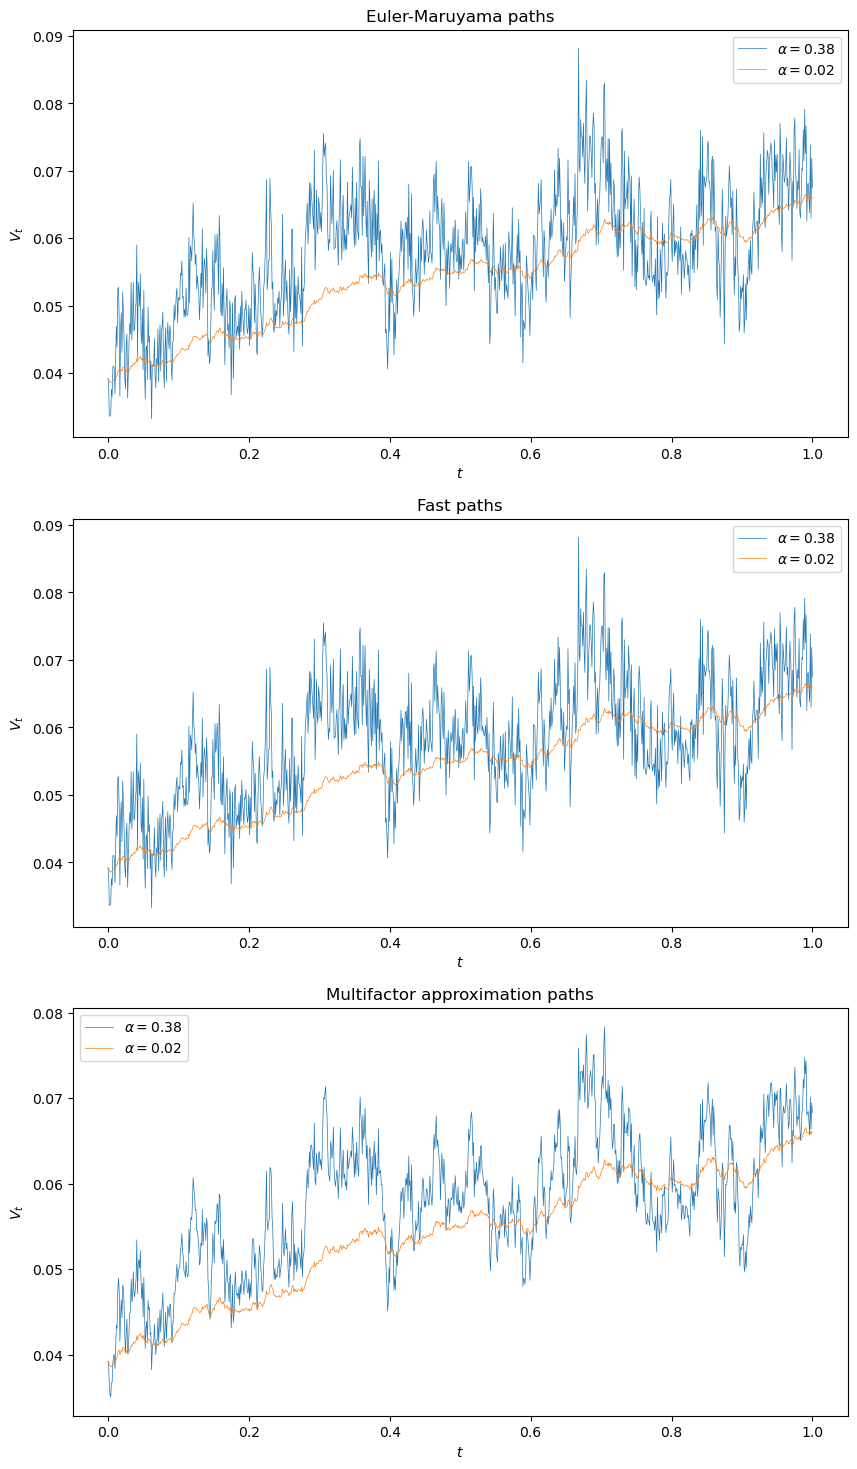

In [8]:
plot_comparison(models, vol_paths, type='alpha')

Observations:
- the paths generated by the Modified Euler-Maruyama algorithm and the Fast algorithm exhibit the same extent of roughness when $\alpha=0.38$, while the paths from the Multifactor approximation algorithm seems smoother.
- the paths of $\alpha=0.38$ is much rougher than that of $\alpha=0.02$, obviously and intuitively

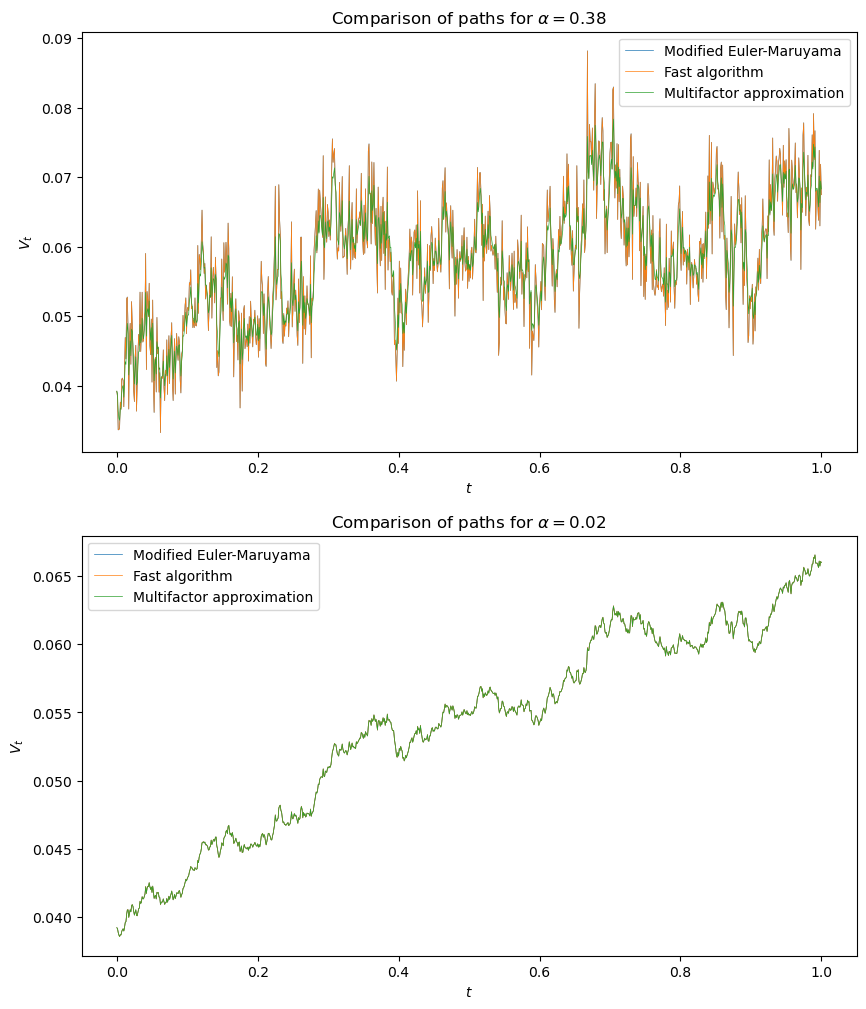

In [9]:
plot_comparison(models, vol_paths, type='algo')

Observations:
- In both cases ($\alpha=0.38$ and $\alpha=0.02$), the Fast algorithm generates very similar paths to that of the Modified Euler-Maruyama algorithm
- While when $\alpha=0.38$, the Multi-factor approximation algorithm performs poorly

### 4.2 Computation time

For $T=1$,

|      |        One path             | One path | 1000 paths simultaneously | 1000 paths simultaneously |
| ---- | -------------- | ---------- | -------------- | --------- |
| # time step | Euler-Maruyama | Fast       | Euler-Maruyama | Fast      |
| 250  | 6.615250       | 8.578748   | 0.115804       | 0.185450  |
| 500  | 14.519335      | 17.271443  | 0.592969       | 0.415592  |
| 1000 | 38.725009      | 34.958345  | 2.544576       | 1.085544  |
| 2000 | 113.862958     | 69.938801  | 8.690365       | 2.323525  |
| 4000 | 368.988235     | 141.535237 | 41.461980      | 5.271604  |
| 6000 | 1391.173844    | 290.813273 | 169.880603     | 15.053457 |

The above computation time is measured in milliseconds (ms). We can see that
- when time step is large, the Fast algorithm takes less time; when time step is small, the Modified Euler-Maruyama algorithm takes less time
- due to vectorization, the average time for generating one path in the latter case, generating 1000 paths simultaneously, is significantly shorter (up to **45x faster**)

#### 4.2.1 Time for one path

In [10]:
import timeit

def test_computation_time(model, texp, n_path, n_ts, algo, num_runs=100):
    method = getattr(model, algo)
    avg_time = np.zeros_like(n_ts, dtype=float)
    total_time = 0

    for i in range(len(n_ts)):
        total_time = 0
        model.set_num_params(texp=texp, n_path=n_path, n_ts=n_ts[i])
        for _ in range(num_runs):
            start_time = timeit.default_timer()

            Z_t1, W_t = model.random_normals()
            V_t = method(Z_t1)

            end_time = timeit.default_timer()

            total_time += end_time - start_time
        avg_time[i] = total_time / num_runs

    return avg_time

In [11]:
n_ts = [250, 500, 1000, 2000, 4000, 8000]
time_EM_1 = test_computation_time(rheston_038, texp=1, n_path=1, n_ts=n_ts, algo='ModifiedEM', num_runs=100)
time_Fast_1 = test_computation_time(rheston_038, texp=1, n_path=1, n_ts=n_ts, algo='Fast', num_runs=100)

In [12]:
comp_time_1 = pd.DataFrame(np.array([time_EM_1 * 1000, time_Fast_1 * 1000]).T, columns=['Euler-Maruyama', 'Fast'], index=n_ts)
comp_time_1

,Euler-Maruyama,Fast
250,6.373338,8.623866
500,14.760952,17.476917
1000,39.267290,35.208251
2000,118.217126,70.250013
4000,377.821802,143.148013
8000,1411.259001,292.102435


#### 4.2.2 Time for 1000 paths

In [13]:
time_EM_1000 = test_computation_time(rheston_038, texp=1, n_path=1000, n_ts=n_ts, algo='ModifiedEM', num_runs=5)
time_Fast_1000 = test_computation_time(rheston_038, texp=1, n_path=1000, n_ts=n_ts, algo='Fast', num_runs=100)

In [14]:
comp_time_1000 = pd.DataFrame(np.array([time_EM_1000, time_Fast_1000]).T, columns=['Euler-Maruyama', 'Fast'], index=n_ts)
comp_time_1000

,Euler-Maruyama,Fast
250,0.127205,0.171822
500,0.519224,0.414234
1000,2.366852,1.038433
2000,8.343565,2.379338
4000,40.999665,4.659156
8000,168.163604,13.723295


### 4.3 Option pricing

Use the same parameters from [Callegaro et al. (2021)](#Callegaro2021), 

$$
S_0=100, \quad V_0=0.0392, \quad \rho=-0.681, \quad \kappa=0.1, \quad \theta=0.3156, \quad \epsilon=0.331, \quad r=0 .
$$

Run the simulation with number of time steps $250$, number of paths $100,000$. Repeat the experiment for $100$ times (note that every time you run you might get different results due to the very nature of MC simulation).

- $\alpha=0.38$:

    | Strike | Algo type | One day | One week | One month | Six months | One year | Two years |
    | --- | --- | --- | --- | --- | --- | --- | --- |
    | 80 | [Callegaro et al. (2021)](#Callegaro2021) | 20 | 20 | 20.0005 | 20.6112 | 22.1366 | 25.4301 |
    |  | Modified EM | 19.99995     | 19.999989 | 20.000658 | 20.607918  | 22.120343 | 25.396956 |
    |  | Fast | 19.99999     | 19.999658 | 20.002350 | 20.602332  | 22.116782 | 25.395223 |
    | 85 | [Callegaro et al. (2021)](#Callegaro2021) | 15 | 15 | 15.0108 | 16.2807 | 18.3529 | 22.2091 |
    |  | Modified EM | 14.99995     | 14.999989 | 15.010846 | 16.274347  | 18.332555 | 22.171247 |
    |  | Fast | 14.99999     | 14.999658 | 15.012470 | 16.269161  | 18.328932 | 22.170455 |
    | 90 | [Callegaro et al. (2021)](#Callegaro2021) | 10 | 10.0002 | 10.1144 | 12.3948 | 14.9672 | 19.2898 |
    |  | Modified EM | 9.999954     | 10.000185 | 10.113493 | 12.384250  | 14.942785 | 19.247781 |
    |  | Fast | 9.999991     | 9.999841  | 10.114984 | 12.380106  | 14.940064 | 19.247814 |
    | 95 | [Callegaro et al. (2021)](#Callegaro2021) | 5.0003 | 5.0491 | 5.6723 | 9.0636 | 12.0059 | 16.6676 |
    |  | Modified EM | 4.999954     | 5.044462  | 5.669319  | 9.049536   | 11.977843 | 16.621762 |
    |  | Fast | 4.999991     | 5.044286  | 5.670852  | 9.046654   | 11.976206 | 16.623111 |
    | 100 | [Callegaro et al. (2021)](#Callegaro2021) | 0.5012 | 1.1347 | 2.3896 | 6.3497 | 9.4737 | 14.3319 |
    |  | Modified EM | 0.4147314    | 1.112365  | 2.384964  | 6.334239   | 9.443891  | 14.283308 |
    |  | Fast | 0.4150257    | 1.112836  | 2.385154  | 6.332006   | 9.442838  | 14.285873 |
    | 105 | [Callegaro et al. (2021)](#Callegaro2021) | 6.39e-05 | 0.04113 | 0.6809 | 4.2550 | 7.3563 | 12.2676 |
    |  | Modified EM | 1.266341e-09 | 0.036536  | 0.677000  | 4.239743   | 7.326027  | 12.217084 |
    |  | Fast | 1.872763e-09 | 0.036802  | 0.677158  | 4.238315   | 7.325250  | 12.220843 |
    | 110 | [Callegaro et al. (2021)](#Callegaro2021) | 2.37e-05 | 9.22e-05 | 0.1205 | 2.7251 | 5.6234 | 10.4562 |
    |  | Modified EM | 0.000000     | 6.3e-05   | 0.119173  | 2.711442   | 5.594169  | 10.404734 |
    |  | Fast | 0.000000 | 6.4e-05   | 0.118996  | 2.710650   | 5.592973  | 10.409524 |
    | 115 | [Callegaro et al. (2021)](#Callegaro2021) | 1.51e-05 | 6.82e-09 | 0.0124 | 1.6680 | 4.2343 | 8.8773 |
    |  | Modified EM | 0.000000     | 0.000000  | 0.012148  | 1.656444   | 4.206951  | 8.825911  |
    |  | Fast | 0.000000 | 0.000000 | 0.012111  | 1.655836   | 4.205541  | 8.831125  |
    | 120 | [Callegaro et al. (2021)](#Callegaro2021) | 1.14e-05 | 1.80e-13 | 7.32e-04 | 0.9761 | 3.1424 | 7.5093 |
    |  | Modified EM | 0.000000 | 0.000000 | 6.88e-04 | 0.967280 | 3.117224 | 7.458775 |
    |  | Fast | 0.000000 | 0.000000 | 6.80e-04 | 0.966998 | 3.115929 | 7.464375 |

- $\alpha=0.0001$ (approximation of regular Heston): 

    | Strike | Algo type | One day | One week | One month | Six months | One year | Two years |
    | --- | --- | --- | --- | --- | --- | --- | --- |
    | 80 | Heston FFT | 19.999817    | 20.00000     | 20.000119 | 20.467789  | 21.882194 | 25.342685 |
    |  | Modified EM | 20.00000     | 20.00032     | 19.998105 | 20.462389  | 21.860666 | 25.300803 |
    |  | Fast | 19.99952     | 19.999954    | 20.000860 | 20.461727  | 21.860129 | 25.292780 |
    | 85 | Heston FFT | 14.999592    | 15.00000     | 15.005036 | 16.065825  | 18.044783 | 22.116098 |
    |  | Modified EM | 15.00000     | 15.00032     | 15.002900 | 16.057406  | 18.019379 | 22.070199 |
    |  | Fast | 14.99952     | 14.999954    | 15.005680 | 16.056862  | 18.019123 | 22.063783 |
    | 90 | Heston FFT | 9.999253     | 10.00005     | 10.081315 | 12.117169  | 14.618737 | 19.193730 |
    |  | Modified EM | 9.999998     | 10.00037     | 10.078289 | 12.105610  | 14.590280 | 19.144437 |
    |  | Fast | 9.999518     | 10.000004    | 10.081064 | 12.105038  | 14.589712 | 19.140126 |
    | 95 | Heston FFT | 5.000421     | 5.033864     | 5.594002  | 8.749388   | 11.634501 | 16.570951 |
    |  | Modified EM | 4.999998     | 5.033804     | 5.589046  | 8.735251   | 11.604186 | 16.519429 |
    |  | Fast | 4.999518     | 5.033394     | 5.591302  | 8.734846   | 11.603791 | 16.516900 |
    | 100 | Heston FFT | 0.416402     | 1.097419     | 2.312255  | 6.033819   | 9.098308  | 14.236957 |
    |  | Modified EM | 0.4127088    | 1.095381     | 2.306016  | 6.018755   | 9.067458  | 14.184353 |
    |  | Fast | 0.4125453    | 1.094800     | 2.308085  | 6.018111   | 9.066277  | 14.183246 |
    | 105 | Heston FFT | -0.000445    | 4.138453e-02 | 0.651703  | 3.969527   | 6.994116  | 12.176208 |
    |  | Modified EM | 4.170842e-07 | 4.093408e-02 | 0.647528  | 3.955276   | 6.964014  | 12.123773 |
    |  | Fast | 6.275091e-08 | 4.0794e-02   | 0.648667  | 3.954494   | 6.962025  | 12.123491 |
    | 110 | Heston FFT | 0.000120     | 1.583470e-04 | 0.119056  | 2.490984   | 5.288288  | 10.369848 |
    |  | Modified EM | 0.000000     | 1.592360e-04 | 0.117548  | 2.478975   | 5.260181  | 10.318662 |
    |  | Fast | 0.000000     | 1.53e-04     | 0.117982  | 2.477623   | 5.257120  | 10.318726 |
    | 115 | Heston FFT | -0.000369    | 5.558204e-08 | 0.013874  | 1.492120   | 3.935542  | 8.796976  |
    |  | Modified EM | 0.000000     | 7.617007e-08 | 0.013623  | 1.482647   | 3.910486  | 8.747960  |
    |  | Fast | 0.000000     | 3.838055e-08 | 0.013697  | 1.480754   | 3.906972  | 8.748086  |
    | 120 | Heston FFT | 0.000544 | 4.916068e-10 | 0.001038 | 0.854310 | 2.884879 | 7.435743 |
    |  | Modified EM | 0.000000 | 0.000000 | 0.000991 | 0.847441 | 2.863103 | 7.389376 |
    |  | Fast | 0.000000 | 0.000000 | 0.001027 | 0.845336 | 2.859503 | 7.389534 |

Observations:
- both methods exhibit downward biases compared to [Callegaro et al. (2021)](#Callegaro2021) in both cases
- both methods are quite accurate when the time to maturity is **less than one year**
- both methods approximate well the regular Heston case when the roughness parameter is set to be $\alpha=0.0001$

In [15]:
def generate_prices(alpha, method, cond=False, correct_fwd=False):
    rheston = pf.RoughHestonMcMaWu2022(V_0=0.0392, rho=-0.681, kappa=0.1, epsilon=0.331, theta=0.3156, alpha=alpha)
    prices = []
    texp = [1/365, 7/365, 1/12, 1/2, 1, 2]
    K = np.linspace(80, 120, 9)

    if not cond:
        if method == 'MEM':
            for t in texp:
                rheston.set_num_params(texp=t, n_path=100_000, n_ts=250)
                temp = []
                for i in range(100):
                    Z_t, W_t = rheston.random_normals()
                    V_t = rheston.ModifiedEM(Z_t)
                    temp += [rheston.price(spot=100, V_t=V_t, W_t=W_t, strike=K)[1]]
                temp = np.array(temp)
                prices += [temp.mean(axis=0)]
                print(f"texp = {t} done")
        elif method == 'Fast':
            for t in texp:
                rheston.set_num_params(texp=t, n_path=100_000, n_ts=250)
                temp = []
                for i in range(100):
                    Z_t, W_t = rheston.random_normals()
                    V_t = rheston.Fast(Z_t)
                    temp += [rheston.price(spot=100, V_t=V_t, W_t=W_t, strike=K)[1]]
                temp = np.array(temp)
                prices += [temp.mean(axis=0)]
                print(f"texp = {t} done")
        else:
            raise ValueError("Invalid method")
    elif cond:
        if method == 'MEM':
            for t in texp:
                rheston.set_num_params(texp=t, n_path=5_000, n_ts=250)
                temp = []
                for i in range(100):
                    Z_t, W_t = rheston.random_normals()
                    V_t = rheston.ModifiedEM(Z_t)
                    temp += [rheston.priceCMC(spot=100, V_t=V_t, Z_t=Z_t, strike=K, correct_fwd=correct_fwd)]
                temp = np.array(temp)
                prices += [temp.mean(axis=0)]
                print(f"texp = {t} done")
        elif method == 'Fast':
            for t in texp:
                rheston.set_num_params(texp=t, n_path=5_000, n_ts=250)
                temp = []
                for i in range(100):
                    Z_t, W_t = rheston.random_normals()
                    V_t = rheston.Fast(Z_t)
                    temp += [rheston.priceCMC(spot=100, V_t=V_t, Z_t=Z_t, strike=K, correct_fwd=correct_fwd)]
                temp = np.array(temp)
                prices += [temp.mean(axis=0)]
                print(f"texp = {t} done")
        else:
            raise ValueError("Invalid method")
    else:
        raise ValueError("Invalid condition")
        
    prices = np.array(prices)
    columns = ['One day', 'One week', 'One month', 'Six months', 'One year', 'Two years']
    prices_df = pd.DataFrame(prices.T, columns=columns, index=K)

    return prices_df

#### 4.3.1 $\alpha=0.38$

In [16]:
prices_038_EM_df = generate_prices(0.38, 'MEM')

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [17]:
prices_038_Fast_df = generate_prices(0.38, 'Fast')

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [18]:
prices_038_EM_df

,One day,One week,One month,Six months,One year,Two years
80.0,1.999990e+01,2.000019e+01,20.001274,20.608368,22.134687,25.385039
85.0,1.499990e+01,1.500019e+01,15.011426,16.274620,18.346397,22.159504
90.0,9.999896e+00,1.000038e+01,10.113995,12.384770,14.956414,19.236334
95.0,4.999897e+00,5.044447e+00,5.669558,9.050161,11.991510,16.610984
100.0,4.148536e-01,1.112559e+00,2.384483,6.333991,9.456561,14.273490
105.0,3.655393e-09,3.658382e-02,0.676937,4.238931,7.337010,12.208595
110.0,0.000000e+00,6.337818e-05,0.119040,2.710009,5.603413,10.397570
115.0,0.000000e+00,2.564223e-08,0.012126,1.654733,4.214677,8.819327
120.0,0.000000e+00,0.000000e+00,0.000674,0.965143,3.124162,7.452747


In [19]:
prices_038_Fast_df

,One day,One week,One month,Six months,One year,Two years
80.0,1.999999e+01,19.999658,20.002350,20.602332,22.116782,25.395223
85.0,1.499999e+01,14.999658,15.012470,16.269161,18.328932,22.170455
90.0,9.999991e+00,9.999841,10.114984,12.380106,14.940064,19.247814
95.0,4.999991e+00,5.044286,5.670852,9.046654,11.976206,16.623111
100.0,4.150257e-01,1.112836,2.385154,6.332006,9.442838,14.285873
105.0,1.872763e-09,0.036802,0.677158,4.238315,7.325250,12.220843
110.0,0.000000e+00,0.000064,0.118996,2.710650,5.592973,10.409524
115.0,0.000000e+00,0.000000,0.012111,1.655836,4.205541,8.831125
120.0,0.000000e+00,0.000000,0.000680,0.966998,3.115929,7.464375


#### 4.3.2 $\alpha=0.0001$ (approximation of regular Heston)

In [20]:
prices_00001_EM_df = generate_prices(0.0001, 'MEM')

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [21]:
prices_00001_Fast_df = generate_prices(0.0001, 'Fast')

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [22]:
prices_00001_EM_df

,One day,One week,One month,Six months,One year,Two years
80.0,2.000011e+01,2.000024e+01,19.999198,20.470069,21.862672,25.306882
85.0,1.500011e+01,1.500024e+01,15.004041,16.065165,18.020874,22.074896
90.0,1.000011e+01,1.000029e+01,10.079541,12.112985,14.591364,19.148494
95.0,5.000115e+00,5.033707e+00,5.590294,8.741915,11.604775,16.522452
100.0,4.128804e-01,1.095537e+00,2.307260,6.024508,9.067755,14.186196
105.0,2.431513e-07,4.094960e-02,0.648325,3.959988,6.964407,12.124321
110.0,0.000000e+00,1.505045e-04,0.117967,2.482051,5.260549,10.318028
115.0,0.000000e+00,1.852700e-07,0.013660,1.484290,3.910076,8.746078
120.0,0.000000e+00,0.000000e+00,0.001033,0.848084,2.862001,7.386278


In [23]:
prices_00001_Fast_df

,One day,One week,One month,Six months,One year,Two years
80.0,1.999952e+01,19.999954,20.000860,20.461727,21.860129,25.292780
85.0,1.499952e+01,14.999954,15.005680,16.056862,18.019123,22.063783
90.0,9.999518e+00,10.000004,10.081064,12.105038,14.589712,19.140126
95.0,4.999518e+00,5.033394,5.591302,8.734846,11.603791,16.516900
100.0,4.125453e-01,1.094800,2.308085,6.018111,9.066277,14.183246
105.0,6.275091e-08,0.040794,0.648667,3.954494,6.962025,12.123491
110.0,0.000000e+00,0.000153,0.117982,2.477623,5.257120,10.318726
115.0,0.000000e+00,0.000000,0.013697,1.480754,3.906972,8.748086
120.0,0.000000e+00,0.000000,0.001027,0.845336,2.859503,7.389534


#### 4.3.3 $\alpha=0$ (regular Heston)

In [24]:
m_hes = pf.HestonFft(0.0392, 0.0331, -0.681, 0.1, 0.3156)
prices_reg_heston = np.array([m_hes.price(np.arange(80, 121, 5), 100, t) for t in [1/365, 7/365, 1/12, 1/2, 1, 2]])
columns = ['One day', 'One week', 'One month', 'Six months', 'One year', 'Two years']
K = np.linspace(80, 120, 9)
prices_reg_heston_df = pd.DataFrame(prices_reg_heston.T, columns=columns, index=K)
prices_reg_heston_df

,One day,One week,One month,Six months,One year,Two years
80.0,19.999817,2.000000e+01,20.000119,20.467789,21.882194,25.342685
85.0,14.999592,1.500000e+01,15.005036,16.065825,18.044783,22.116098
90.0,9.999253,1.000005e+01,10.081315,12.117169,14.618737,19.193730
95.0,5.000421,5.033864e+00,5.594002,8.749388,11.634501,16.570951
100.0,0.416402,1.097419e+00,2.312255,6.033819,9.098308,14.236957
105.0,-0.000445,4.138453e-02,0.651703,3.969527,6.994116,12.176208
110.0,0.000120,1.583470e-04,0.119056,2.490984,5.288288,10.369848
115.0,-0.000369,5.558204e-08,0.013874,1.492120,3.935542,8.796976
120.0,0.000544,4.916068e-10,0.001038,0.854310,2.884879,7.435743


### 4.4 Conditional MC pricing

1. **Stochastic Differential Equation:**
   $$
   dS_t = r S_t dt + S_t \sqrt{V_t} dW_t = r S_t dt + S_t \sqrt{V_t} (\rho dZ_t + \sqrt{1 - \rho^2} dX_t)
   $$

2. **Logarithmic Transformation of the Stochastic Process:**
   $$
   d \log S_t = \left(r - \frac{1}{2} V_t\right) dt + \rho \sqrt{V_t} dZ_t + \sqrt{1 - \rho^2} \sqrt{V_t} dX_t
   $$

3. **Integrated Form:**
   $$
   \log \frac{S_T}{S_0} = \int_0^T \left(r - \frac{1}{2} V_t\right) dt + \rho \int_0^T \sqrt{V_t} dZ_t + \sqrt{1 - \rho^2} \int_0^T  \sqrt{V_t} dX_t
   $$
   where $Z_t \sim N(0,1)$ and $X_t \sim N(0,1)$.

4. **Definitions:**
   $$
   V_{0,T} = \int_0^T V_t dt, \quad Y_{0,T} = \int_0^T \sqrt{V_t} dZ_t
   $$

5. **Distribution of the Log Price Ratio:**
   $$
   \log \frac{S_T}{S_0} \sim N(\mu, \sigma^2), \quad \text{where } \mu = rT - \frac{1}{2} V_{0,T} + \rho Y_{0,T}, \quad \sigma^2 = (1 - \rho^2) V_{0,T}
   $$

6. **Expression for Expected Values:**
   $$
   F_T = E[S_T | V_{0,T}, Y_{0,T}] = S_0 \exp(rT - \frac{\rho^2}{2} V_{0,T} + \rho Y_{0,T})
   $$

7. **Martingale-Corrected Control Variate ([Choi, 2024](#Choi2024)):**
   $$
   F_T = e^{rT} \frac{S_T}{S_0} \quad \text{(observable)}
   $$
   $$
   F_T^{\text{adj}} = \mu F_T, \quad \text{where } \mu = \frac{S_0 e^{rT}}{{E_{MC}} \{S_T\}}
   $$

8. **Conditional Monte Carlo Method:**
   $$
   F_T^{\text{cond}} = S_0 \exp \left(rT - \frac{\rho^2}{2} V_{0,T} + \rho Y_{0,T}\right), \quad \sigma_{\text{BS}} = \sqrt{(1-\rho^2) \frac{V_{0,T}}{T}}
   $$

- $\alpha=0.38$

   | Strike | Algorithm type                            | One day           | One week         | One month     | Six months    | One year      | Two years     |
   | ------ | ----------------------------------------- | ----------------- | ---------------- | ------------- | ------------- | ------------- | ------------- |
   | 80     | [Callegaro et al. (2021)](#Callegaro2021) | 20                | 20               | 20.0005       | 20.6112       | 22.1366       | 25.4301       |
   |        | Modified EM with CV                       | 20.00000          | 20.00000         | 20.000530     | 20.609109     | 22.129968     | 25.422332     |
   |        | Modified EM w/o CV                        | 19.99983          | 20.00021         | 19.999787     | 20.606124     | 22.129474     | 25.477061     |
   |        | **Fast with CV**                          | **20.00000**      | **20.00000**     | **20.000538** | **20.611888** | **22.137081** | **25.435017** |
   |        | Fast w/o CV                               | 20.00067          | 20.00472         | 20.008197     | 20.585916     | 22.133908     | 25.474415     |
   | 85     | [Callegaro et al. (2021)](#Callegaro2021) | 15                | 15               | 15.0108       | 16.2807       | 18.3529       | 22.2091       |
   |        | Modified EM with CV                       | 15.00000          | 15.00000         | 15.010835     | 16.276725     | 18.343795     | 22.199614     |
   |        | Modified EM w/o CV                        | 14.99983          | 15.00021         | 15.010181     | 16.276702     | 18.344420     | 22.252617     |
   |        | **Fast with CV**                          | **15.00000**      | **15.00000**     | **15.010865** | **16.280416** | **18.353397** | **22.213900** |
   |        | Fast w/o CV                               | 15.00067          | 15.00472         | 15.018561     | 16.256534     | 18.348606     | 22.249163     |
   | 90     | [Callegaro et al. (2021)](#Callegaro2021) | 10                | 10.0002          | 10.1144       | 12.3948       | 14.9672       | 19.2898       |
   |        | Modified EM with CV                       | 10.00000          | 10.00019         | 10.114211     | 12.388313     | 14.955774     | 19.278633     |
   |        | Modified EM w/o CV                        | 9.999833          | 1.000040         | 10.114112     | 12.391560     | 14.957537     | 19.329577     |
   |        | **Fast with CV**                          | **10.00000**      | **10.00019**     | **10.114671** | **12.393068** | **14.967755** | **19.294171** |
   |        | Fast w/o CV                               | 10.00067          | 10.00492         | 10.122112     | 12.372094     | 14.961186     | 19.325278     |
   | 95     | [Callegaro et al. (2021)](#Callegaro2021) | 5.0003            | 5.0491           | 5.6723        | 9.0636        | 12.0059       | 16.6676       |
   |        | Modified EM with CV                       | 5.000001          | 5.044647         | 5.671089      | 9.054696      | 11.992320     | 16.654927     |
   |        | Modified EM w/o CV                        | 4.999834          | 5.045212         | 5.672491      | 9.060704      | 11.995165     | 16.703512     |
   |        | **Fast with CV**                          | **5.000001**      | **5.044777**     | **5.673019**  | **9.060427**  | **12.006290** | **16.671345** |
   |        | Fast w/o CV                               | 5.000667          | 5.049759         | 5.679269      | 9.042810      | 11.998023     | 16.698425     |
   | 100    | [Callegaro et al. (2021)](#Callegaro2021) | 0.5012            | 1.1347           | 2.3896        | 6.3497        | 9.4737        | 14.3319       |
   |        | Modified EM with CV                       | 0.4149906         | 1.112954         | 2.386992      | 6.339111      | 9.458633      | 14.317996     |
   |        | Modified EM w/o CV                        | 0.4158441         | 1.114555         | 2.389364      | 6.346683      | 9.462410      | 14.363978     |
   |        | **Fast with CV**                          | **0.4155871**     | **1.115461**     | **2.389992**  | **6.345394**  | **9.473991**  | **14.334933** |
   |        | Fast w/o CV                               | 0.4164436         | 1.117977         | 2.394024      | 6.331204      | 9.464327      | 14.358234     |
   | 105    | [Callegaro et al. (2021)](#Callegaro2021) | 6.39e-05          | 0.04113          | 0.6809        | 4.2550        | 7.3563        | 12.2676       |
   |        | Modified EM with CV                       | 2.436080e-08      | 0.03675033       | 0.678549      | 4.243822      | 7.340336      | 12.252691     |
   |        | Modified EM w/o CV                        | 2.482031e-08      | 0.03703575       | 0.680147      | 4.251537      | 7.344810      | 12.295893     |
   |        | **Fast with CV**                          | **2.289915e-08**  | **0.03722695**   | **0.680539**  | **4.250018**  | **7.356372**  | **12.269816** |
   |        | Fast w/o CV                               | 2.530729e-08      | 0.03742150       | 0.682432      | 4.239042      | 7.345771      | 12.289666     |
   | 110    | [Callegaro et al. (2021)](#Callegaro2021) | 2.37e-05          | 9.22e-05         | 0.1205        | 2.7251        | 5.6234        | 10.4562       |
   |        | Modified EM with CV                       | 3.516076e-29      | 6.528633e-05     | 0.119568      | 2.714625      | 5.607318      | 10.440569     |
   |        | Modified EM w/o CV                        | 3.331314e-29      | 6.700341e-05     | 0.120089      | 2.721348      | 5.612209      | 10.480884     |
   |        | **Fast with CV**                          | **1.297250e-29**  | **6.722972e-05** | **0.120137**  | **2.720129**  | **5.623322**  | **10.457595** |
   |        | Fast w/o CV                               | 1.362368e-29      | 6.993088e-05     | 0.120779      | 2.711987      | 5.612315      | 10.474375     |
   | 115    | [Callegaro et al. (2021)](#Callegaro2021) | 1.51e-05          | 6.82e-09         | 0.0124        | 1.6680        | 4.2343        | 8.8773        |
   |        | Modified EM with CV                       | 6.613290e-67      | 2.960521e-09     | 0.012311      | 1.658989      | 4.218688      | 8.861141      |
   |        | Modified EM w/o CV                        | 2.278257e-66      | 3.378017e-09     | 0.012397      | 1.664140      | 4.223710      | 8.898525      |
   |        | **Fast with CV**                          | **2.918629e-67**  | **3.366561e-09** | **0.012378**  | **1.663431**  | **4.234036**  | **8.877828**  |
   |        | Fast w/o CV                               | 4.501162e-67      | 3.905222e-09     | 0.012514      | 1.657660      | 4.223142      | 8.891936      |
   | 120    | [Callegaro et al. (2021)](#Callegaro2021) | 1.14e-05          | 1.80e-13         | 7.32e-04      | 0.9761        | 3.1424        | 7.5093        |
   |        | Modified EM with CV                       | 6.011237e-118     | 2.224291e-15     | 7.14e-04      | 0.969069      | 3.127826      | 7.492930      |
   |        | Modified EM w/o CV                        | 3.677774e-117     | 3.670066e-15     | 7.22e-04      | 0.972603      | 3.132726      | 7.527398      |
   |        | **Fast with CV**                          | **4.299807e-117** | **3.095697e-15** | **7.17e-04**  | **0.972362**  | **3.142032**  | **7.509087**  |
   |        | Fast w/o CV                               | 5.203278e-117     | 4.202524e-15     | 7.32e-04      | 0.968476      | 3.131696      | 7.520915      |

Observations:
- the Fast algorithm with the martingale preserving control variate used (**Fast with CV**) performs the best, especially when time to maturity is larger than or equal to 1
- with only 5,000 paths, the prices are more accurate compared to the unconditional ones with 100,000 paths
- the accuracy is further improved when the martingale preserving control variate is used
- the standard deviation (not shown here) is reduced using conditional MC, and even more reduced using the martingale preserving control variate

#### 4.4.1 Pricing with martingale-preserving control variate

In [25]:
prices_038_EM_CMC_cv_df = generate_prices(0.38, 'MEM', cond=True, correct_fwd=True)

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [26]:
prices_038_Fast_CMC_cv_df = generate_prices(0.38, 'Fast', cond=True, correct_fwd=True)

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [27]:
prices_038_EM_CMC_cv_df

,One day,One week,One month,Six months,One year,Two years
80.0,2.000000e+01,2.000000e+01,20.000566,20.611105,22.137023,25.425759
85.0,1.500000e+01,1.500000e+01,15.010958,16.280125,18.352044,22.203644
90.0,1.000000e+01,1.000021e+01,10.114703,12.393392,14.964935,19.283168
95.0,5.000001e+00,5.045281e+00,5.672741,9.061240,12.002037,16.659855
100.0,4.158528e-01,1.115665e+00,2.389578,6.346390,9.468511,14.323210
105.0,2.449195e-08,3.719510e-02,0.680378,4.250873,7.349987,12.258091
110.0,1.639046e-29,6.794302e-05,0.120152,2.720651,5.616404,10.446070
115.0,1.713086e-66,3.460999e-09,0.012397,1.663597,4.226955,8.866673
120.0,4.097357e-117,3.813142e-15,0.000721,0.972274,3.135116,7.498439


In [28]:
prices_038_Fast_CMC_cv_df

,One day,One week,One month,Six months,One year,Two years
80.0,2.000000e+01,2.000000e+01,20.000538,20.611888,22.137081,25.435017
85.0,1.500000e+01,1.500000e+01,15.010865,16.280416,18.353397,22.213900
90.0,1.000000e+01,1.000019e+01,10.114671,12.393068,14.967755,19.294171
95.0,5.000001e+00,5.044777e+00,5.673019,9.060427,12.006290,16.671345
100.0,4.155871e-01,1.115461e+00,2.389992,6.345394,9.473991,14.334933
105.0,2.289915e-08,3.722695e-02,0.680539,4.250018,7.356372,12.269816
110.0,1.297250e-29,6.722972e-05,0.120137,2.720129,5.623322,10.457595
115.0,2.918629e-67,3.366561e-09,0.012378,1.663431,4.234036,8.877828
120.0,4.299807e-117,3.095697e-15,0.000717,0.972362,3.142032,7.509087


#### 4.4.2 Pricing without martingale-preserving control variate

In [29]:
prices_038_EM_CMC_df = generate_prices(0.38, 'MEM', cond=True, correct_fwd=False)

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [30]:
prices_038_Fast_CMC_df = generate_prices(0.38, 'Fast', cond=True, correct_fwd=False)

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [31]:
prices_038_EM_CMC_df

,One day,One week,One month,Six months,One year,Two years
80.0,1.999983e+01,2.000021e+01,19.999787,20.606124,22.129474,25.477061
85.0,1.499983e+01,1.500021e+01,15.010181,16.276702,18.344420,22.252617
90.0,9.999833e+00,1.000040e+01,10.114112,12.391560,14.957537,19.329577
95.0,4.999834e+00,5.045212e+00,5.672491,9.060704,11.995165,16.703512
100.0,4.158441e-01,1.114555e+00,2.389364,6.346683,9.462410,14.363978
105.0,2.482031e-08,3.703575e-02,0.680147,4.251537,7.344810,12.295893
110.0,3.331314e-29,6.700341e-05,0.120089,2.721348,5.612209,10.480884
115.0,2.278257e-66,3.378017e-09,0.012397,1.664140,4.223710,8.898525
120.0,3.677774e-117,3.670066e-15,0.000722,0.972603,3.132726,7.527398


In [32]:
prices_038_Fast_CMC_df

,One day,One week,One month,Six months,One year,Two years
80.0,2.000067e+01,2.000472e+01,20.008197,20.585916,22.133908,25.474415
85.0,1.500067e+01,1.500472e+01,15.018561,16.256534,18.348606,22.249163
90.0,1.000067e+01,1.000492e+01,10.122112,12.372094,14.961186,19.325278
95.0,5.000667e+00,5.049759e+00,5.679269,9.042810,11.998023,16.698425
100.0,4.164436e-01,1.117977e+00,2.394024,6.331204,9.464327,14.358234
105.0,2.530729e-08,3.742150e-02,0.682432,4.239042,7.345771,12.289666
110.0,1.362368e-29,6.993088e-05,0.120779,2.711987,5.612315,10.474375
115.0,4.501162e-67,3.905222e-09,0.012514,1.657660,4.223142,8.891936
120.0,5.203278e-117,4.202524e-15,0.000732,0.968476,3.131696,7.520915


## References

<a id="Ma2022"></a>
[1] Ma, J. and Wu, H. (2022) A fast algorithm for simulation of rough volatility models, Quantitative Finance, 22:3, 447-462, DOI: [10.1080/14697688.2021.1970213](https://doi.org/10.1080/14697688.2021.1970213)

<a id="Callegaro2021"></a>
[2] Callegaro, G., Grasselli, M. and Pagès, G. (2021) Fast Hybrid Schemes for Fractional Riccati Equations (Rough Is Not So
Tough). Mathematics of Operations Research 46(1):221-254. DOI: [10.1287/moor.2020.1054](https://doi.org/10.1287/moor.2020.1054)

<a id="AbiJaber2019"></a>
[3] Abi Jaber, E., & El Euch, O. (2019). Multifactor approximation of rough volatility models. SIAM journal on financial mathematics, 10(2), 309-349. DOI: [10.1137/18M1170236](https://doi.org/10.1137/18M1170236)

<a id="Olver2010"></a>
[4] Olver, F.W.J., Lozier, D.W., Boisvert, R.F. and Clark, C.W., NIST Handbook of Mathematical Functions, 2010 (Cambridge University Press: New York).

<a id="Jiang2017"></a>
[5] Jiang, S., Zhang, J., Zhang, Q., & Zhang, Z. (2017). Fast evaluation of the Caputo fractional derivative and its applications to fractional diffusion equations. Communications in Computational Physics, 21(3), 650-678. DOI: [10.4208/cicp.OA-2016-0136](https://doi.org/10.4208/cicp.OA-2016-0136)

<a id="Choi2024"></a>
[6] Choi, J. (2024). Exact simulation scheme for the Ornstein-Uhlenbeck driven stochastic volatility model with the Karhunen-Lo\eve expansions. arXiv preprint arXiv:2402.09243. DOI: [10.48550/arXiv.2402.09243](https://doi.org/10.48550/arXiv.2402.09243)